In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import squidpy as sq
import anndata as ad
import seaborn as sns
import networkx as nx
import pandas as pd

import sys
sys.path.append("../src/")
sys.path.append("/data/bionets/je30bery/truncated_graphs/src/")
from truncated_graphs import *

- create random spatial data
- connect nearest neighbors
- compute centrality scores
- for variable r, truncate graph by border r and compute centralities for everything inside, taking only nodes insight the new "window" into account
- calculate error of new and old centralities
- scatter

In [4]:
measure = "degree"
n = 256
bounds=(0, 20)
coordinates = generate_coordinates(n=n, bounds=bounds, type="regular")
adata_original = create_anndata(coordinates, n_neighs=4, bounds=bounds)
compute_centrality_measures(adata_original)
borders = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

error_dfs = dict()
adatas_truncated = dict()
centralities_truncated = dict()

for border in borders:
    adatas_truncated[border] = filter_border_nodes(adata_original, border=border, bounds=bounds)
    compute_centrality_measures(adatas_truncated[border])
    compute_node_errors_and_distances(adata_original=adata_original, 
                                      adata_truncated=adatas_truncated[border],
                                      bounds=bounds)

/data/bionets/je30bery/truncated_graphs/notebooks/../src/truncated_graphs.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata_truncated.obs["distance_to_border"] = adata_original.obs['distance_to_border'][np.array(adata_truncated.obs_names).astype(int)]
/data/bionets/je30bery/truncated_graphs/notebooks/../src/truncated_graphs.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata_truncated.obs["distance_to_border"] = adata_original.obs['distance_to_border'][np.array(adata_truncated.obs_names).astype(int)]
/data/bionets/je30bery/truncated_graphs/notebooks/../src/truncated_graphs.py:95: FutureWarning: Series

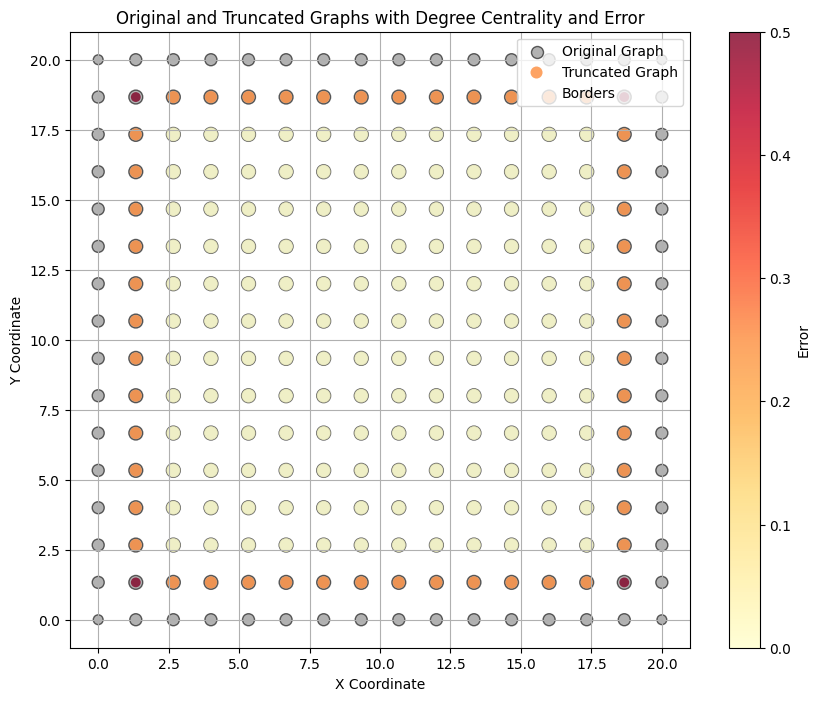

In [12]:
border = 1
plot_graphs_with_errors(adata_original, adatas_truncated[border], border=border, measure=measure, bounds=bounds)

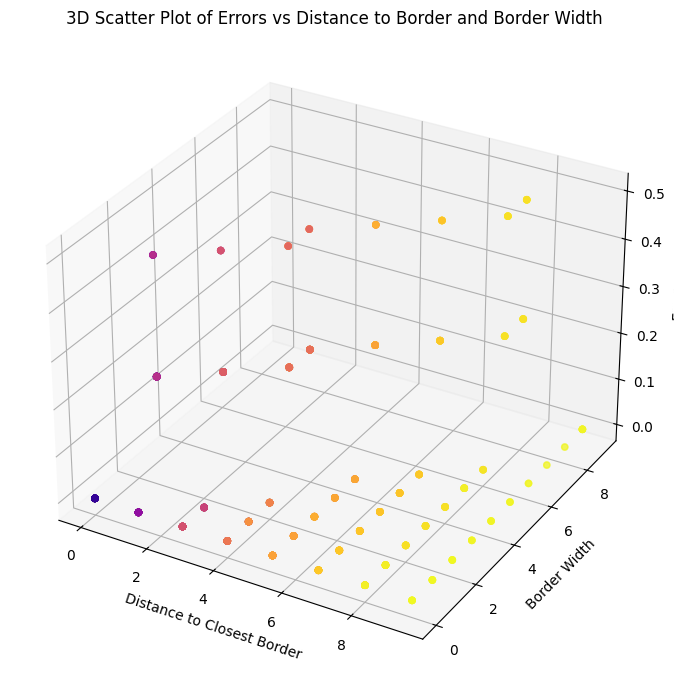

In [13]:
measure = "degree"

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
pal = sns.color_palette("plasma", len(adatas_truncated[0]))

for i, border in enumerate(adatas_truncated.keys()):
    ax.scatter(adatas_truncated[border].obs["distance_to_border"], [border] * len(adatas_truncated[border]), adatas_truncated[border].obs[f"{measure} error"], 
           color=np.array(pal)[adatas_truncated[border].obs_names.values.astype(int)], marker='o')

ax.set_xlabel('Distance to Closest Border')
ax.set_ylabel('Border Width')
ax.set_zlabel('Error')
ax.set_title('3D Scatter Plot of Errors vs Distance to Border and Border Width')
plt.tight_layout()
#plt.savefig(f"../result_plots/{measure}.png", bbox_inches="tight")